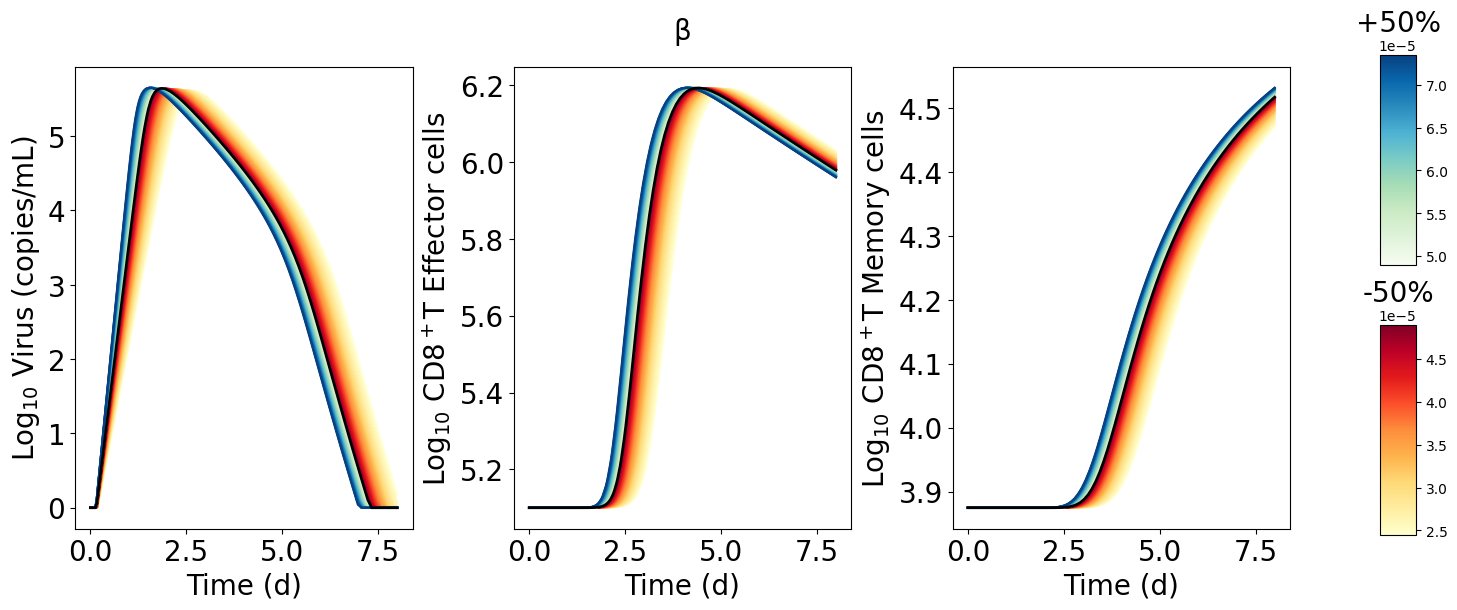

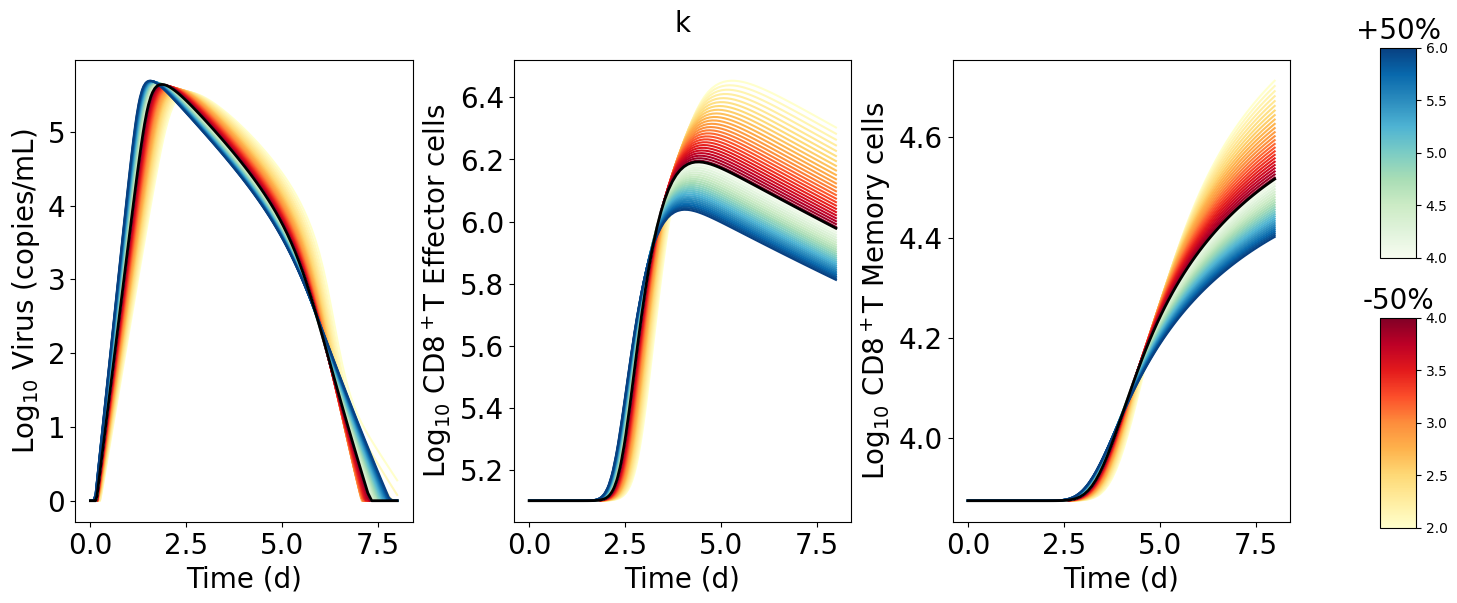

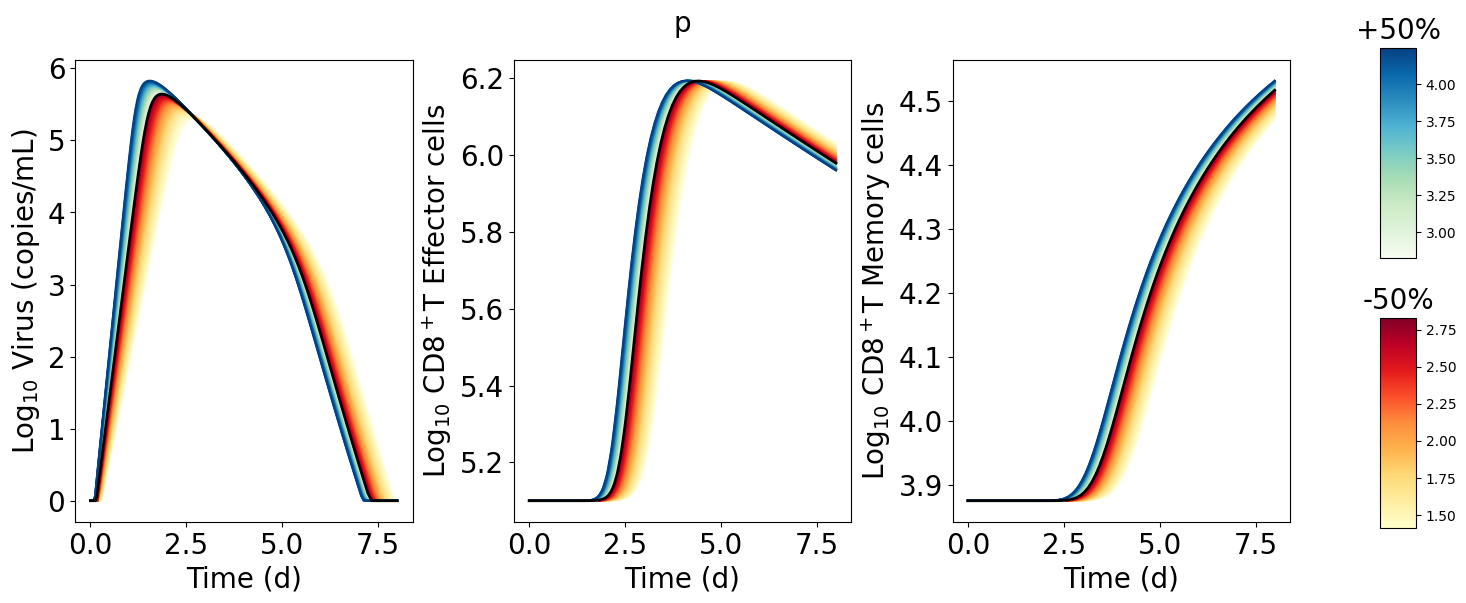

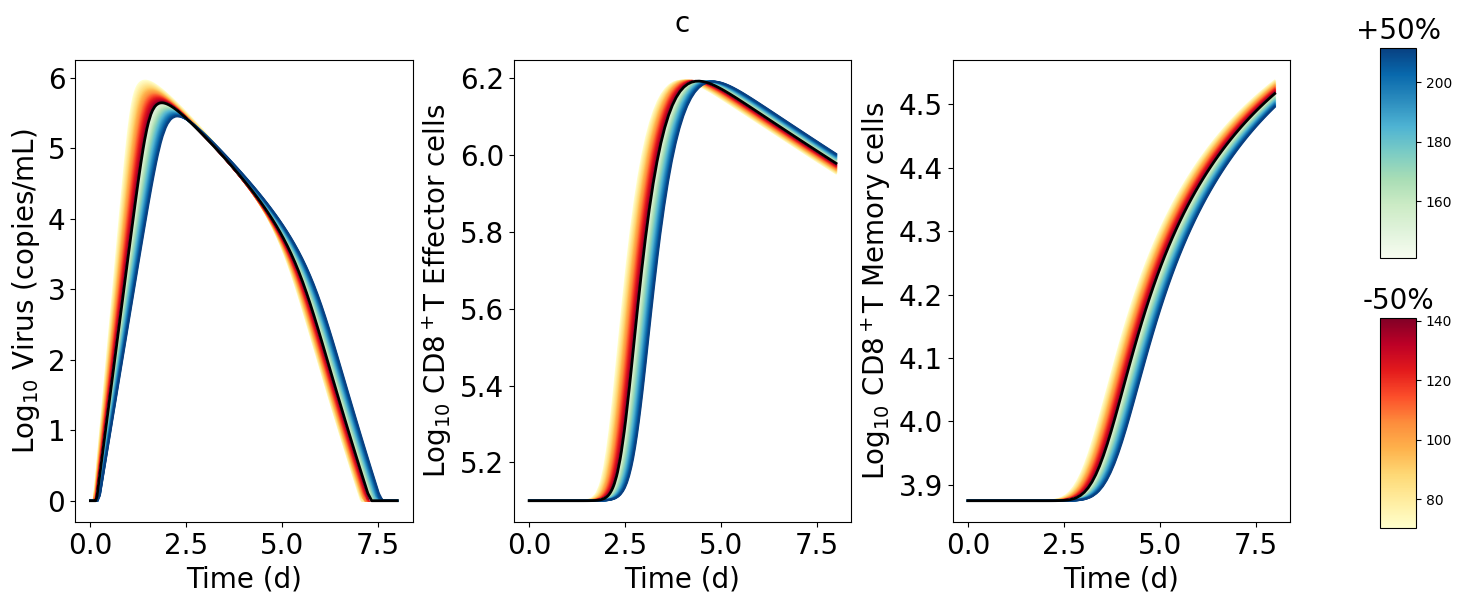

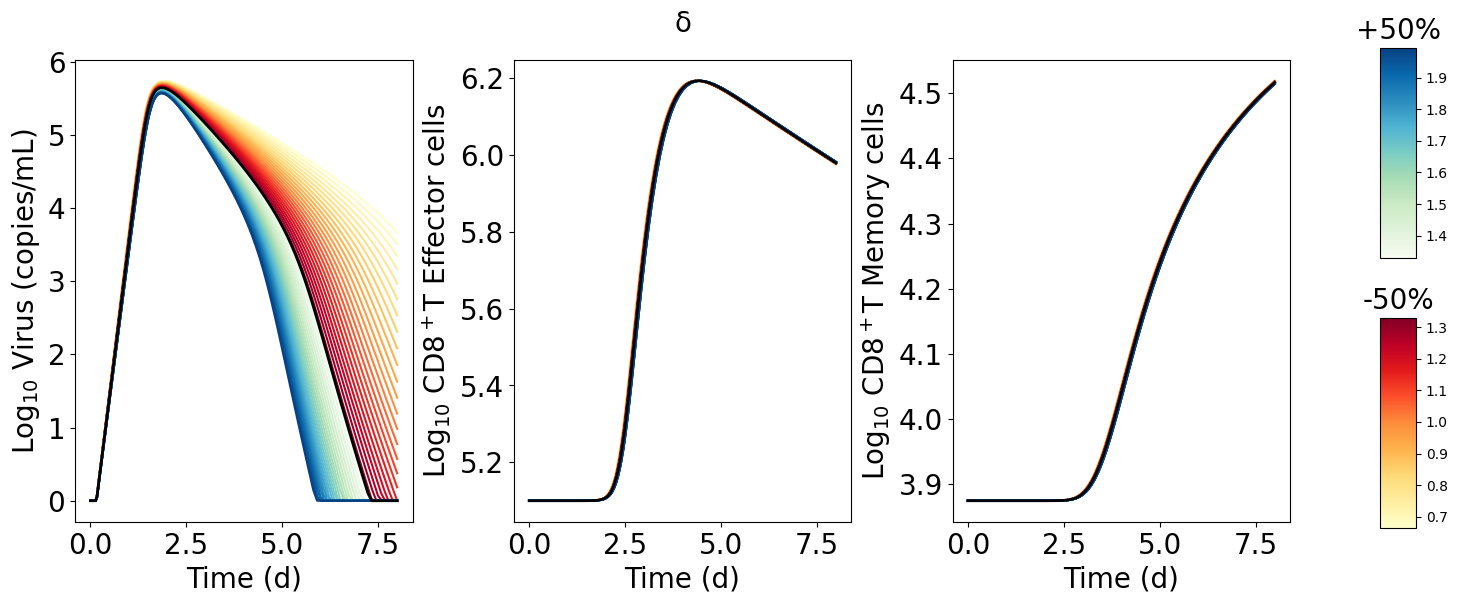

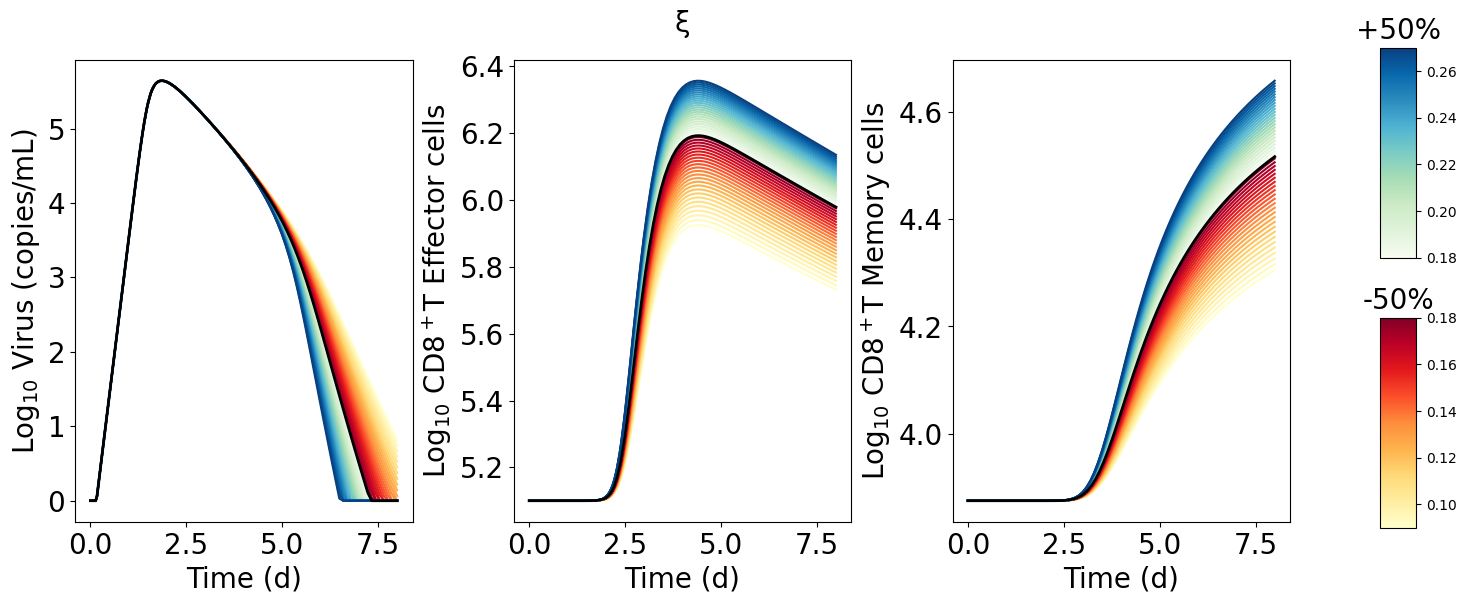

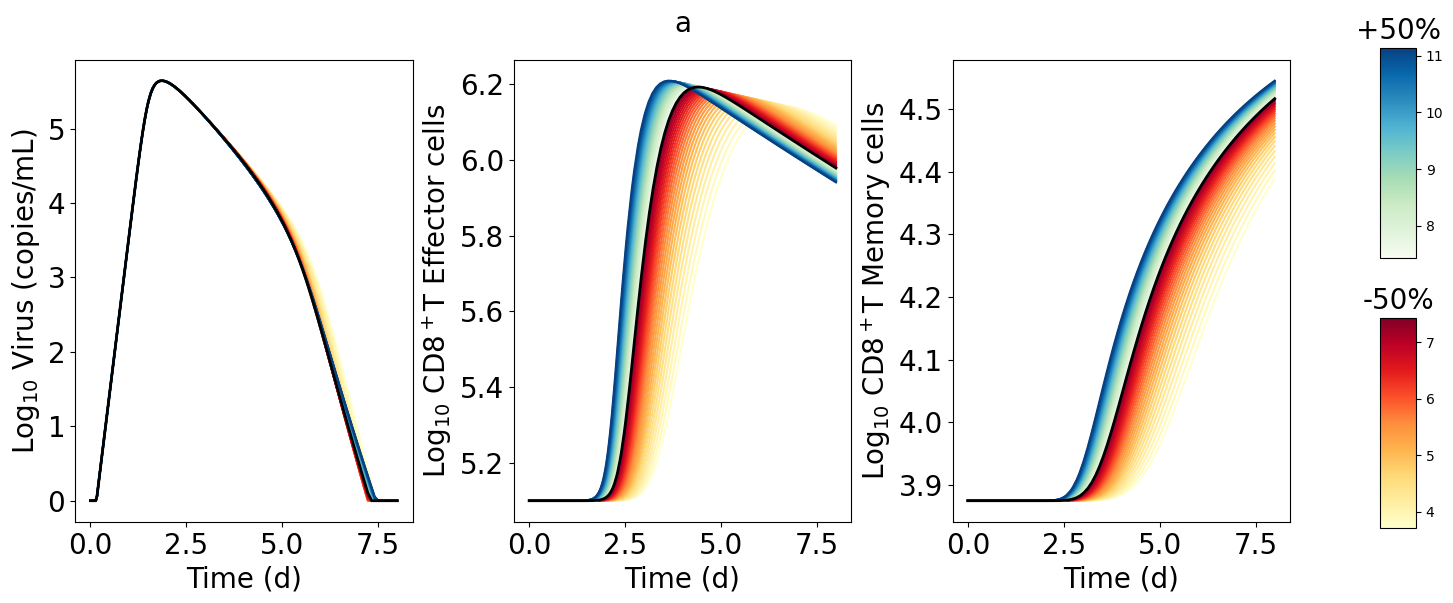

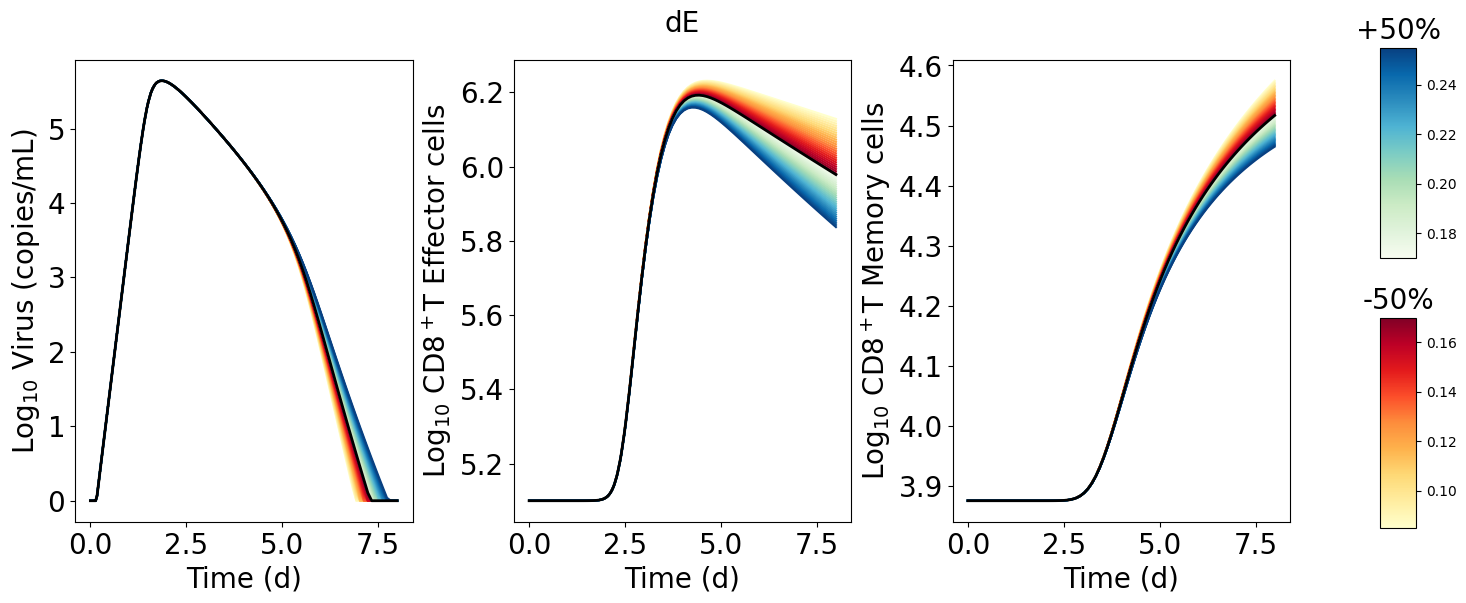

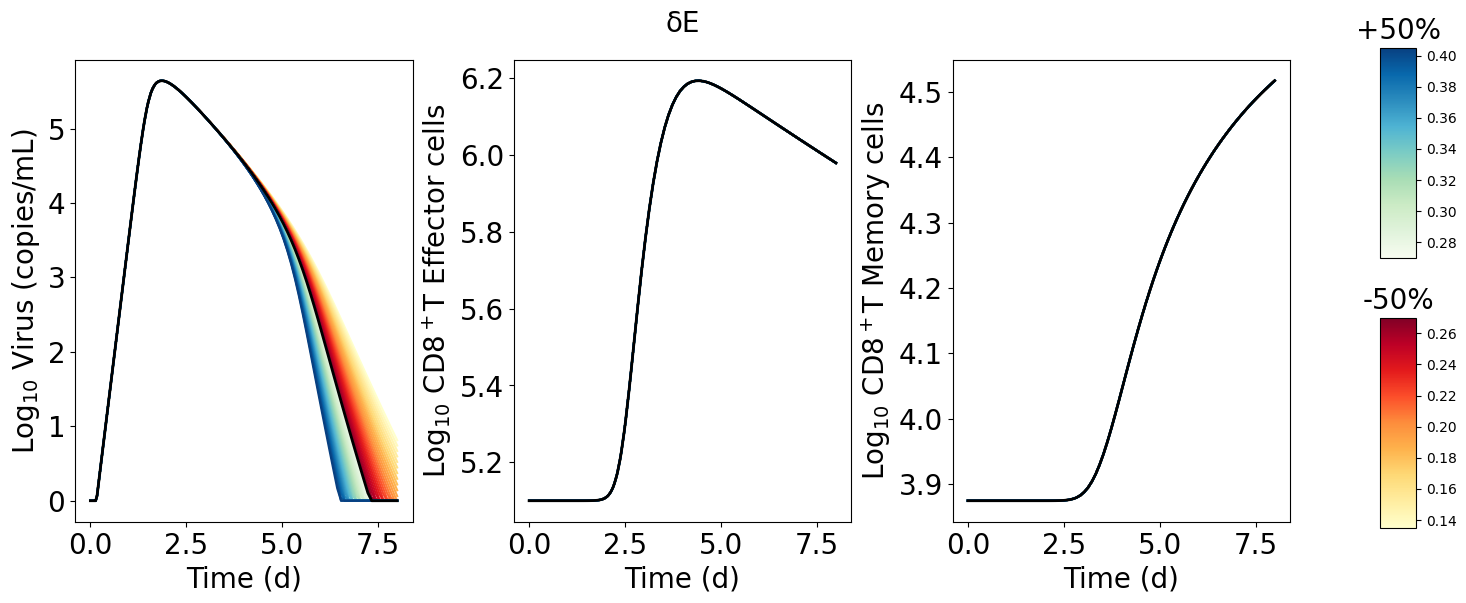

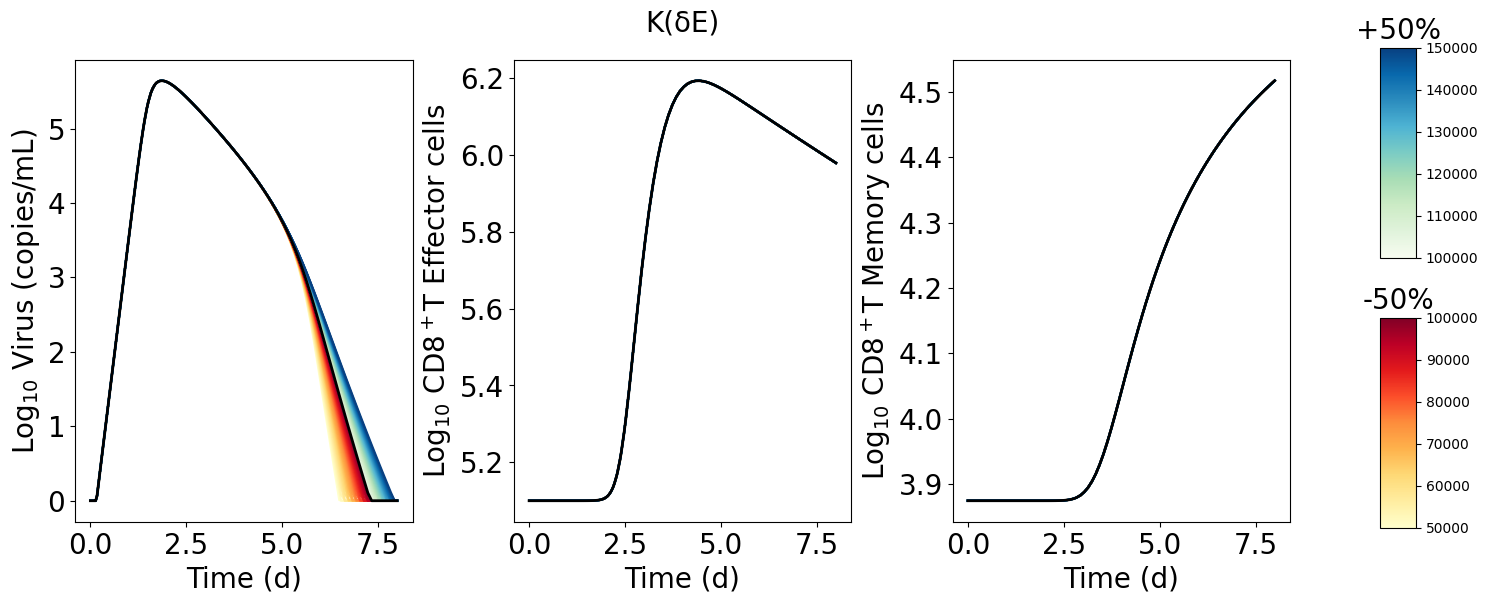

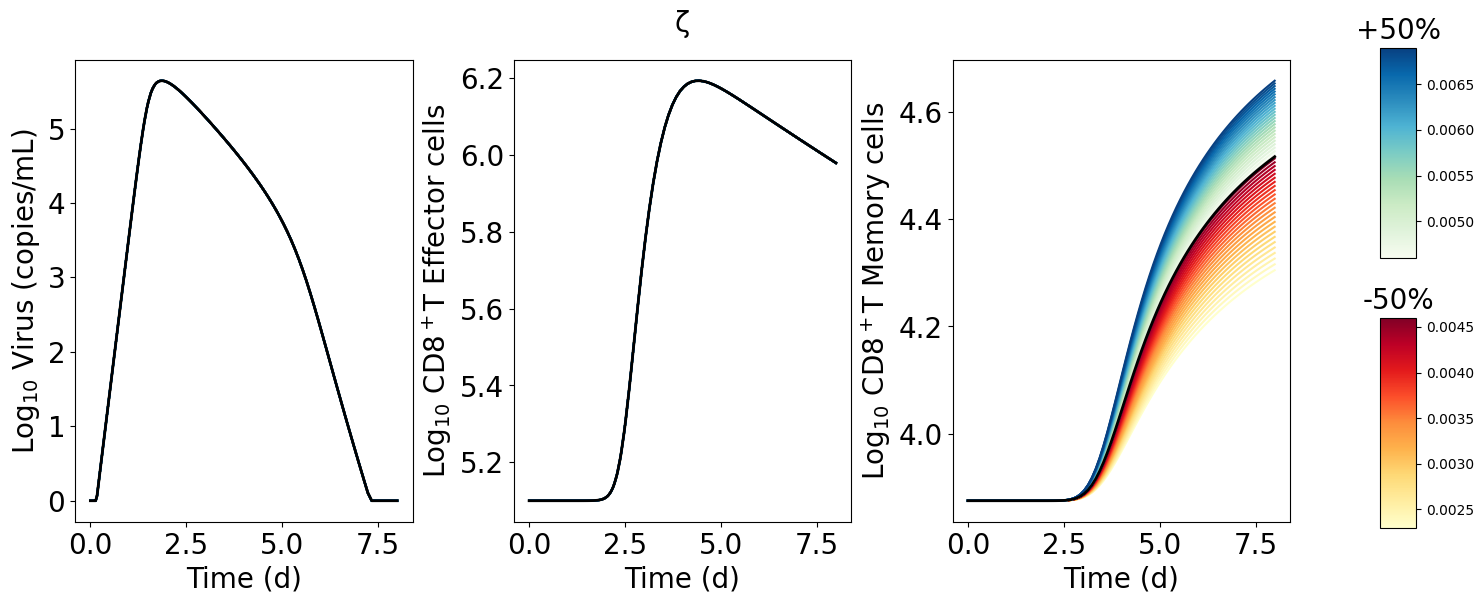

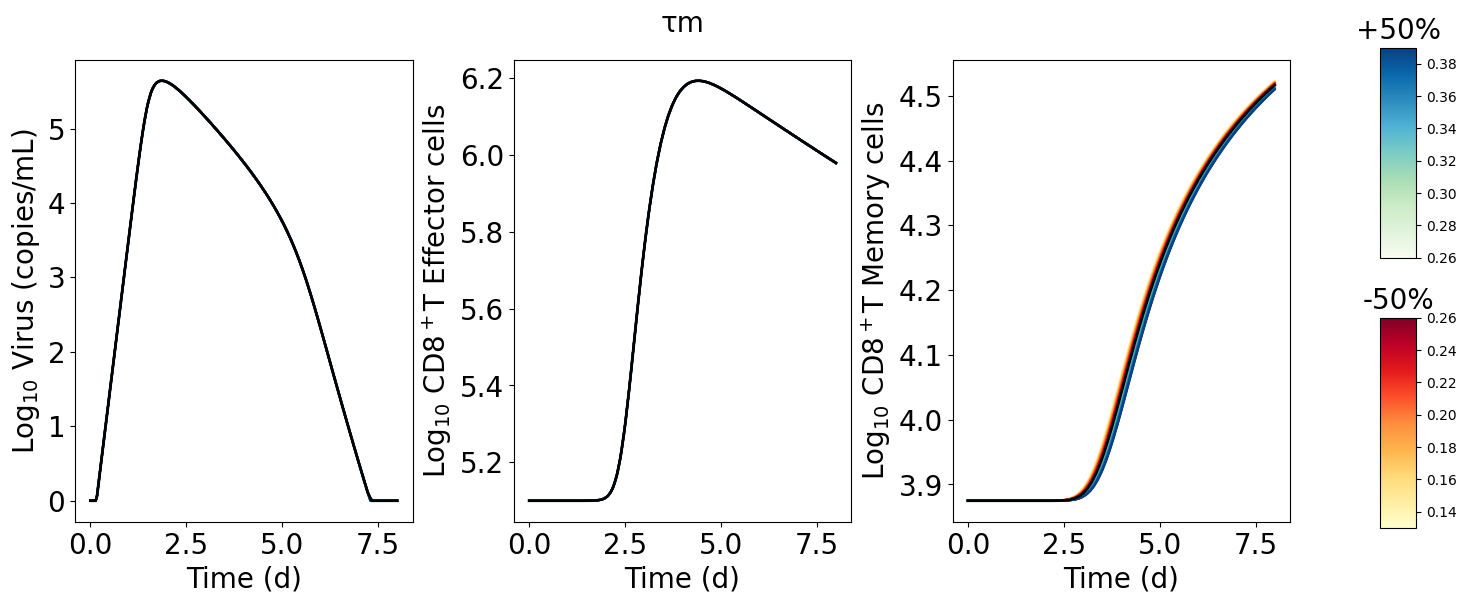

In [87]:
import os
os.environ["JULIA_NUM_THREADS"] = "1"
from julia.api import Julia
julia = Julia(sysimage="sysimage.so")
from julia import Main
Main.include("memory_model.jl")
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib as mpl

def format_fit_params(fit_parameters):
    if isinstance(fit_parameters, list) and len(fit_parameters) > 1:
        fit_params_str = " ".join(fit_parameters)
    else:
        fit_params_str = fit_parameters[0] if isinstance(fit_parameters, list) else fit_parameters
    
    # Define the replacements
    replacements = {
        r"\bd_E\b": "dE",  # d_E -> d subscript E
        r"\bdelta\b": "δ",  # delta -> δ
        r"\bdelta_E\b": "δE",  # delta_E -> δ subscript E
        r"\bK_delta_E\b": "K(δE)",  # K_delta_E -> K subscript δ subscript E
        r"\btau\b": "τ",  # tau -> τ
        r"\bxi\b": "ξ",  # xi -> ξ
        r"\bbeta\b": "β",  # beta -> β
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",  # delta_E/K_delta_E -> δ subscript E/K subscript δ subscript E
        r"\bdelta/delta_E\b": "δ/δE",  # delta/delta_E -> δ divided by δ subscript E
        r"\beta\b": "η",  # eta -> η
        r"\bzeta\b": "ζ",  # zeta -> ζ
        r"\btau_memory\b": "τm",  # tau_memory -> τ subscript m
    }

    # Apply the replacements using regex
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)

    return fit_params_str

def solve_with_sweep(t_span, y0, Zero_conditions, base_params, sweep_param, n_steps, percent=50):
    # Convert inputs to Python-friendly types
    t_span = tuple(map(float, t_span))
    y0 = [float(y) for y in y0]

    # Calculate the base parameter value and sweep range
    base_value = base_params[sweep_param]
    sweep_range = (base_value * (1 - percent / 100), base_value * (1 + percent / 100))

    # Generate parameter sweep values
    sweep_values = np.linspace(sweep_range[0], sweep_range[1], n_steps)
    solutions = []

    for value in sweep_values:
        # Update parameters for the current sweep value
        params = base_params.copy()
        params[sweep_param] = value

        # Simulate using your model
        t_values, y_values = Main.tmap_LCTModel(t_span, y0, list(params.values()))

        # Store solutions
        solution = {
            "t": np.array(t_values, dtype=np.float64),
            "y": np.array(y_values, dtype=np.float64)
        }
        solutions.append(solution)

    # Plot results
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Define color maps for decreasing and increasing values
    cmap_decrease = plt.get_cmap("YlOrRd")
    cmap_increase = plt.get_cmap("GnBu")

    # Split indices for decreasing and increasing values
    decreased_indices = np.where(sweep_values < base_value)[0]
    increased_indices = np.where(sweep_values >= base_value)[0]

    # Normalize color maps
    norm_decrease = mpl.colors.Normalize(vmin=sweep_values[decreased_indices].min(), vmax=base_value)
    norm_increase = mpl.colors.Normalize(vmin=base_value, vmax=sweep_values[increased_indices].max())

    base_font_size = 20

    for i, ax in enumerate(axs):
        for j, solution in enumerate(solutions):
            if j in decreased_indices:
                color = cmap_decrease(norm_decrease(sweep_values[j]))
            else:
                color = cmap_increase(norm_increase(sweep_values[j]))

            # Add Zero_conditions "E0" to plot 2 and "M0" to plot 3
            if i == 1:  # CD8T Effector cells
                ax.plot(solution["t"], np.log10(np.maximum(solution["y"][i + 3, :] + Zero_conditions["E0"], 1)), color=color)
            elif i == 2:  # CD8T Memory cells
                ax.plot(solution["t"], np.log10(np.maximum(solution["y"][i + 3, :] + Zero_conditions["M0"], 1)), color=color)
            else:
                ax.plot(solution["t"], np.log10(np.maximum(solution["y"][i + 3, :], 1)), color=color)

        # Apply Zero_conditions logic to baseline case
        baseline_t, baseline_y = Main.tmap_LCTModel(t_span, y0, list(base_params.values()))
        baseline = np.log10(np.maximum(baseline_y[i + 3, :] + (Zero_conditions["E0"] if i == 1 else Zero_conditions["M0"] if i == 2 else 0), 1))
        ax.plot(baseline_t, baseline, color="black", linewidth=2, label="Cohort")

    # Add specific axis labels
    axs[0].set_ylabel(f'Log$_{{10}}$ Virus (copies/mL)', fontsize=base_font_size)
    axs[1].set_ylabel(f'Log$_{{10}}$ CD8$^+$T Effector cells', fontsize=base_font_size)
    axs[2].set_ylabel(f'Log$_{{10}}$ CD8$^+$T Memory cells', fontsize=base_font_size)

    # Only set xlabel for all subplots
    for ax in axs:
        ax.set_xlabel("Time (d)", fontsize=base_font_size)
        ax.tick_params(labelsize=base_font_size)

    # Add a centered title for T Effector plot
    axs[1].set_title(f"{format_fit_params(sweep_param)}", fontsize=base_font_size, pad=20)

    # Create legend with gradients
    fig.subplots_adjust(right=0.8)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    cbar_ax_decrease = fig.add_axes([0.85, 0.1, 0.02, 0.35])
    cbar_ax_increase = fig.add_axes([0.85, 0.55, 0.02, 0.35])

    mpl.colorbar.ColorbarBase(cbar_ax_decrease, cmap=cmap_decrease, norm=norm_decrease, orientation='vertical')
    cbar_ax_decrease.set_title("-50%", fontsize=base_font_size)

    mpl.colorbar.ColorbarBase(cbar_ax_increase, cmap=cmap_increase, norm=norm_increase, orientation='vertical')
    cbar_ax_increase.set_title("+50%", fontsize=base_font_size)

    plt.show()

# Define problem parameters
t_span = (0.0, 8)  
y0 = [4E7, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0] * 13 
base_params = {
    "beta": 0.000049,
    "k": 4.0,
    "p": 2.83,
    "c": 141.0,
    "delta": 1.33,
    "xi": 0.18,
    "a": 7.43,
    "d_E": 0.17,
    "delta_E": 0.27,
    "K_delta_E": 100000,
    "zeta": 0.0046,
    "eta": 0,
    "K_I1": 1.0,
    "tau_memory": 0.26
}
Zero_conditions =  {"E0": 1.26e5, "M0": 7497}  
n_steps = 50  
percent = 50

for param in base_params:
    if param not in ["eta", "K_I1"]:
        sweep_param = param
        solve_with_sweep(t_span, y0, Zero_conditions, base_params, sweep_param, n_steps, percent)